In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
import matplotlib as mpl
from scipy.signal import convolve2d
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from scipy.ndimage import measurements
import sys
from fractions import Fraction


In [8]:
def start(M,p):
    """
    Crée une grille de taille M*M, avec une occupation 1-p.
    Les cases de la grille sont remplies avec des entiers de valeur 0, 1 ou -1 qui représentent respectivement
    les cases vides, les cases occupées par des habitants rouges, et les cases occupées par des habitants bleus.
    
    Paramètres :
    - M (int) : la taille de la grille carrée.
    - p (float) : la proportion d'occupation de la grille, 1-p représente la proportion de cases vides.
    
    Renvoie : 
    - Grille (array) : la grille créée.
    """
    Grille = np.zeros([M,M])
    for i in range(M):
        for j in range(M):
            x,y = i,j
            r = random.random()
            if r <= p:
                Grille[x,y]=0
            if p<r<=(1+p)/2:
                Grille[x,y]=1
            if (1+p)/2<r<=1:
                Grille[x,y]=-1
    return Grille




def convol_local(conv,x,y,xx,yy,M):
    """
    Lorsqu'un habitant déménage, diminue de 1 les cases du tableau de convol de ses anciens voisins, 
    et augmente de 1 celle de ses nouveaux voisins.
    
    Paramètres :
    - conv (array) : un tableau de convolution contenant les voisins de chaque case.
    - x, y (int) : les coordonnées de l'habitant qui déménage.
    - xx, yy (int) : les coordonnées de la case où l'habitant emménage.
    - M (int) : la taille de la grille carrée.
    
    Renvoie : 
    - conv (array) : le tableau de convolution mis à jour.
    """
    conv[max(0,x-1):min(M,x+2),max(0,y-1):min(M,y+2)]-=1
    conv[max(0,xx-1):min(M,xx+2),max(0,yy-1):min(M,yy+2)]+=1
    conv[x,y]+=1
    conv[xx,yy]-=1
    return conv


def Energie(Grille,b_neighs,r_neighs,neighs,K):
    """
    Calcule l'énergie totale du système pour une grille donnée.
    L'énergie totale est la somme de l'énergie d'interaction et de l'énergie du désordre.
    
    Paramètres :
    - Grille (array) : la grille pour laquelle on calcule l'énergie.
    - b_neighs (array) : un tableau de convolution contenant le nombre de voisins bleus autour de chaque case.
    - r_neighs (array) : un tableau de convolution contenant le nombre de voisins rouges autour de chaque case.
    - neighs (array) : un tableau de convolution contenant le nombre total de voisins (bleus + rouges) autour de chaque case.
    - K (float) : le coefficient de l'énergie du désordre.
    
    Renvoie :
    - L'énergie totale du système"""

    E1 = np.sum(Grille*(-b_neighs+r_neighs))
    E2 = np.sum(neighs)

    return -E1 - K*E2


# Kernel pour la convolution
KERNEL = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

def movement(Grille, M, L, T, en=False, kw='fill'):
    
    """Prend en paramètre, la grille de départ, sa taille M, la tolérance L, et le nombre d'itérations T à effectuer.

    D'abord, on crée 3 tableaux à l'aide de la fonction convolution.
    le b_neighs, est un tableau dont la valeur de chaque case représente le nombre de voisins bleue autour de cette case.
    même principe pour r_neighs, tandis que neighs compte les voisins bleues et rouge autour de chaque case. 

    Ensuite, on tire au hasard la couleur de l'habitant à déplacer.
    Si sa couleur est bleu, on utilise r_neighs et neighs pour trouver toute les places disponibles tq r_neighs/neighs<=L
    Ensuite, on tire au hasard une place dispo, et on y place l'habitant. 

    Les tableaux b_neighs, r_neighs, neighs sont ensuite mis à jour avec la fonction convol_local pour éviter de les 
    recalculer

    La fonction s'arrête prématurément si aucune place n'est dispo pendant 100 boucles
    
    Paramètres :
    - Grille : une grille numpy de dimension MxM où chaque case peut être vide (0), bleue (-1) ou rouge (1).
    - M : la taille de la grille.
    - L : la tolérance de Schelling, un entier représentant le pourcentage minimum d'habitants de même couleur autour de chaque case.
    - T : le nombre d'itérations à effectuer.
    - kw : le mode de bordure pour la convolution, par défaut 'fill'.
    - en : False -> ne calcule pas l'énergie, True -> Calcule l'energie, renvoit la grille et e, contenant les énergies

    La fonction retourne la grille après T itérations, et le tableau de l'énergie à chaque itération si en = True
    """
      
    # Initialisation des tableaux de voisins pour les cases bleues, rouges et toutes couleurs confondues
    b_neighs = convolve2d(Grille == -1, KERNEL, boundary=kw, mode='same')
    r_neighs = convolve2d(Grille == 1, KERNEL, boundary=kw, mode='same')
    neighs   = convolve2d(Grille != 0,  KERNEL, boundary=kw, mode='same')
    
    # Liste des coordonnées des cases bleues et rouges
    liste_bx, liste_by = np.where(Grille == -1)
    liste_rx, liste_ry = np.where(Grille == 1)
    
    # Compteur de boucles consécutives sans modifications de la grille
    stop = 0
    E = []
      
    while T != 0:
        # Choix aléatoire de la couleur de l'habitant à déplacer
        c = np.random.choice([-1, 1])
        
        # Si c est -1, on déplace un habitant bleu
        if c == -1:
            liste_x, liste_y = liste_bx, liste_by
            place = (r_neighs / neighs <= L) & (Grille == 0)
        
        # Si c est 1, on déplace un habitant rouge
        if c == 1:
            liste_x, liste_y = liste_rx, liste_ry
            place = (b_neighs / neighs <= L) & (Grille == 0)
                        
        place_x, place_y = np.where(place)
        
        # Si aucune place disponible, on passe à l'itération suivante
        if place_x.size == 0:
            T -= 1 
            stop += 1
            # Si aucune place disponible pendant 100 boucles, on arrête le programme
            if stop >= 100:
                break
            else:
                continue
            
        # Choix aléatoire d'une place disponible
        k1 = np.random.randint(0, place_x.size)
        xx, yy = [place_x[k1], place_y[k1]]
        
        # Choix aléatoire d'un habitant de même couleur à déplacer
        k2 = np.random.randint(0, liste_x.size)
        x, y = liste_x[k2], liste_y[k2]
        
        # Déplacement
    
        Grille[xx,yy]=c
        Grille[x,y]=0
        
        
        # Mise à jour des tableaux de convolution
        neighs = convol_local(neighs,x,y,xx,yy,M)
        
        if c==-1:
            b_neighs=convol_local(b_neighs,x,y,xx,yy,M)
            liste_bx[k2],liste_by[k2]=xx,yy
        if c==1 : 
            r_neighs=convol_local(r_neighs,x,y,xx,yy,M)
            liste_rx[k2],liste_ry[k2]=xx,yy
        
        T -= 1 
        stop = 0
        
        #Calcul de l'énergie
        if en==True:
            E.append(Energie(Grille,b_neighs,r_neighs,neighs,2*L-1))
   
    if en == False : 
        return Grille
    if en == True : 
        return Grille, np.array(E)

    
def movement2(Grille, M, L, T, en=False, kw='fill'):
    
    """ Même fonctionnement que la fonction précédente, mais cette fois-ci on choisit un habitant au hasard
    parmis les habitants non satisfait. 
    
    Paramètres :
    - Grille : une grille numpy de dimension MxM où chaque case peut être vide (0), bleue (-1) ou rouge (1).
    - M : la taille de la grille.
    - L : la tolérance de Schelling, un entier représentant le pourcentage minimum d'habitants de même couleur autour de chaque case.
    - T : le nombre d'itérations à effectuer.
    - kw : le mode de bordure pour la convolution, par défaut 'fill'.
    - en : False -> ne calcule pas l'énergie, True -> Calcule l'energie, renvoit la grille et e, contenant les énergies

    La fonction retourne la grille après T itérations, et le tableau de l'énergie à chaque itération si en = True 
    """
    
    # Initialisation des tableaux de voisins pour les cases bleues, rouges et toutes couleurs confondues
    b_neighs = convolve2d(Grille == -1, KERNEL, boundary=kw, mode='same')
    r_neighs = convolve2d(Grille == 1, KERNEL, boundary=kw, mode='same')
    neighs   = convolve2d(Grille != 0,  KERNEL, boundary=kw, mode='same')
    
    # Liste des coordonnées des cases bleues et rouges
    liste_bx, liste_by = np.where(Grille == -1)
    liste_rx, liste_ry = np.where(Grille == 1)
    
    # Compteur de boucles consécutives sans modifications de la grille
    stop = 0
    E = []
      
    while T != 0:
 
        # Choix aléatoire de la couleur de l'habitant à déplacer
        c=np.random.choice([-1,1])
        
        # Si c est -1, on cherche tout les bleus non satisfaits ainsi que les places qui leur seront acceptable
        if c==-1:
            insatisfait = (r_neighs / neighs > L) & ((Grille ==-1))
            place = (r_neighs / neighs <= L) & ((Grille ==0) )
        
        # Si c est 1, on cherche tout les rouges non satisfaits ainsi que les places qui leur seront acceptable
        if c==1:
            insatisfait = (b_neighs / neighs > L) & ((Grille ==1))
            place = (b_neighs / neighs <= L) & ((Grille ==0) )
                        
        place_x,place_y=np.where(place==True)
        liste_x,liste_y=np.where(insatisfait==True)
                                                      
        
        # Si aucune place disponible ou tout les agents sont satisfaits, on passe à l'itération suivante
        if place_x.size==0 or liste_x.size==0:
            T -= 1 
            stop+=1
            if stop>=1000:
                break
            else:
                continue
        
        # Choix aléatoire d'une place disponible
        k1 = np.random.randint(0,place_x.size)
        xx,yy = [place_x[k1],place_y[k1]]
        
        # Choix aléatoire d'un habitant à déplacer
        k2 = np.random.randint(0,liste_x.size)
        x,y=liste_x[k2],liste_y[k2]
        
        # Déplacement
        Grille[x,y]=0
        Grille[xx,yy]=c
        
        
        
        # Mise à jour des tableaux de convolution
        neighs = convol_local(neighs,x,y,xx,yy,M)
        
        if c==-1:
            b_neighs=convol_local(b_neighs,x,y,xx,yy,M)
            
        if c==1 : 
            r_neighs=convol_local(r_neighs,x,y,xx,yy,M)
        
        T -= 1 
        stop = 0
        
        # Calcul de l'énergie
        if en==True:
            E.append(Energie(Grille,b_neighs,r_neighs,neighs,2*L-1))
   
    if en == False : 
        return Grille
    if en == True : 
        return Grille, np.array(E)


def clusterfct(Grille, M):
    '''
    Attribue un numéro unique à chaque habitant dans la grille, puis parcourt la grille en partant du coin 
    supérieur gauche. Si deux habitants de la même couleur sont voisins latéraux, la fonction propage la valeur minimale 
    attribuée entre ces deux habitants. Le résultat final est un tableau avec chaque cluster numéroté.
    
    Paramètres:
        - Grille (ndarray): La grille de départ.
        - M (int): La taille de la grille.
    
    Renvoie:
        - ndarray: Le tableau avec chaque cluster numéroté.
    '''
    
    # Création de la grille pour chaque couleur
    GrilleB = np.zeros([M, M]) + (Grille == -1)
    GrilleR = np.zeros([M, M]) + (Grille == 1)

    # Numérotation des clusters pour chaque couleur
    cb, nb = measurements.label(GrilleB)
    cr, nr = measurements.label(GrilleR)
    
    sol = np.zeros([M, M])
    
    # Parcours de la grille pour attribuer les numéros de cluster
    for i in range(M):
        for j in range(M):
            if Grille[i, j] == 0:
                sol[i, j] = 0
            if Grille[i, j] == -1:
                sol[i, j] = cb[i, j]
            if Grille[i, j] == 1:
                sol[i, j] = cr[i, j] + nb
    
    return sol

def coeff(Grille, Cluster, M):
    """
    Calcule le coefficient de clusterisation pour une grille donnée.

    Paramètres:
    Grille : array_like
        Une grille Schelling.
    Cluster : array_like
        Une grille numérotée représentant les clusters dans la grille Schelling.
    M : int
        La taille de la grille.

    Renvoie:
        float : Le coefficient de clusterisation.

    Notes
    -----
    Le coefficient de clusterisation est défini comme suit :
    - Pour chaque cluster dans la grille Schelling, on calcule la taille du cluster.
    - On somme le carré des tailles de chaque cluster.
    - On divise le résultat par le carré du nombre total d'habitants dans la grille.

    Le coefficient de clusterisation mesure la quantité de groupes homogènes dans la grille Schelling.

    """
    # Trouver tous les clusters dans la grille
    C = np.unique(Cluster)[1:]

    # Calculer le nombre total d'habitants dans la grille
    Ntot = np.sum(Grille == 1) + np.sum(Grille == -1)

    # Calculer le nombre d'habitants dans chaque cluster
    nc = []
    for c in C:
        nc.append(np.sum(Cluster == c))
    nc = np.array(nc)

    # Calculer le coefficient de clusterisation
    return (2 / Ntot ** 2) * np.sum(nc * nc)

def couleur_grille(Grille, M):
    """
    Transforme une grille en une image RGB en attribuant des couleurs aux différents états.

    Paramètres:
       - Grille (ndarray): Tableau représentant une grille de jeu avec des valeurs {-1, 0, 1}.
       - M (int): Taille de la grille.

    Renvoie:
       - ndarray: Tableau représentant l'image RGB de la grille où les cases rouges sont rouges, les cases
        bleues sont bleues et les cases vides sont blanches.
    """
    
    # Initialisation de la matrice RGB
    img = np.arange(M*M*3).reshape(M, M, 3)
    
    # Attribution des couleurs
    for i in range(M):
        for j in range(M):
            if Grille[i, j] == -1:
                img[i, j] = [204, 0, 0]  # rouge
            if Grille[i, j] == 0:
                img[i, j] = [255, 255, 255]  # blanc
            if Grille[i, j] == 1:
                img[i, j] = [0, 0, 153]  # bleu
    return img

def couleur_cluster(Cluster, M):
    '''
    Attribue à chaque cluster un code couleur aléatoire et renvoie une image RGB de la grille 
    colorée en fonction des clusters.
    
    Paramètres:
       - Cluster: np.array, un tableau de dimension (M,M) représentant les différents clusters de la grille
       - M: int, la taille de la grille
        
    Renvoie:
       - img: np.array, un tableau RGB de dimension (M,M,3) représentant les différentes couleurs attribuées 
        aux clusters.
    '''
    
    # Initialisation de la matrice RGB
    img = np.arange(M*M*3).reshape(M,M,3) 
    
    # Couleur blanche pour les cases vides
    rgb=[[255,255,255]]
    
    # Attribution d'une couleur aléatoire à chaque cluster
    val = np.unique(Cluster)
    for j in range(val.size):
        rgb.append((np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)))
        
    # Attribution des couleurs aux cases appartenant aux clusters
    k=0
    for c in val:
        x,y = np.where(Cluster==c)
        for i in range(x.size):
            img[x[i],y[i]] = rgb[k]
        k+=1
        
    return img
    

Text(0.5, 0.98, 'Modèle de Schelling')

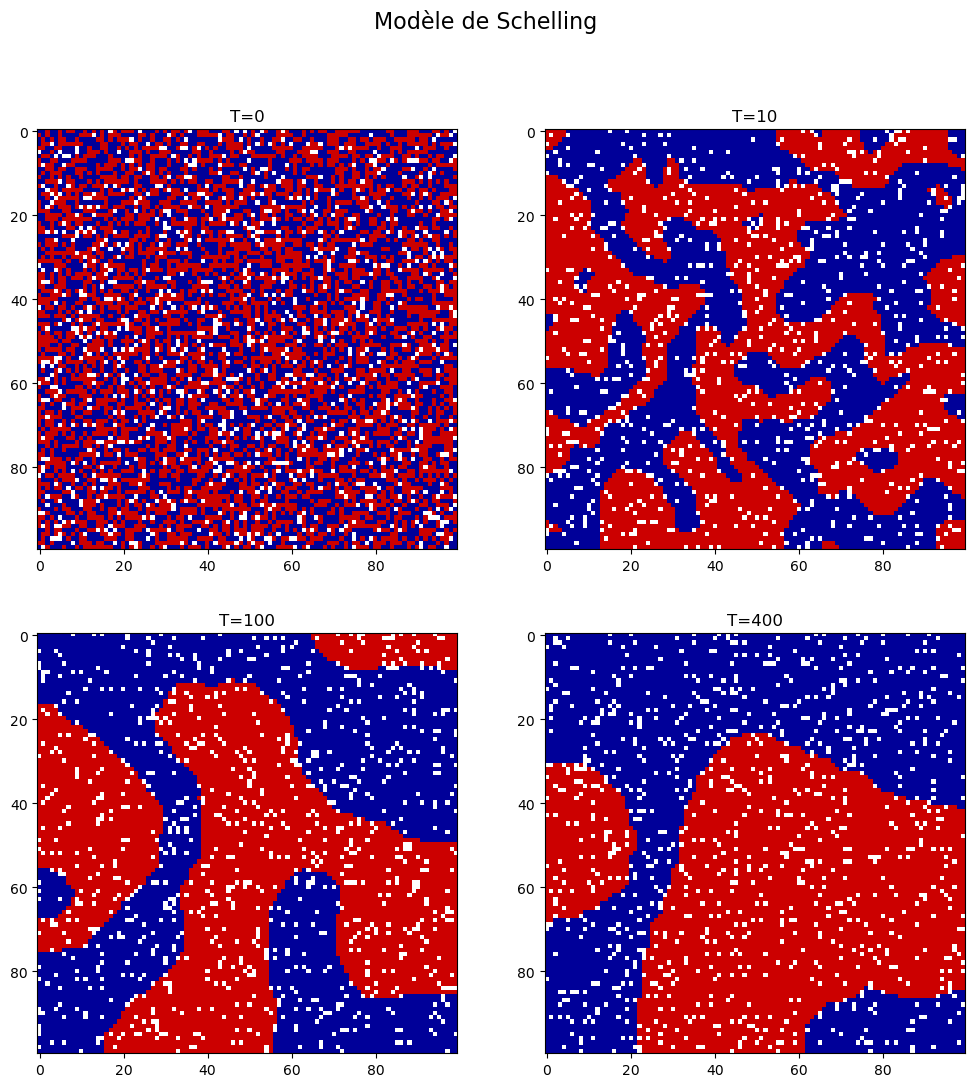

In [3]:
M = 100
L = 0.49
vide = 0.1
T = [10,90,300]
V = [0,10,100,400]

Grille = start(M,vide)
start_time = time.time()
fig = plt.figure(figsize=(12,12))
i = 1
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(couleur_grille(Grille,M)) 
ax1.set_title(f'T={V[i-1]}')
for t in T:
    Grille = movement(Grille,M,L,M*M*t)  
    ax1 = fig.add_subplot(2,2,i+1)
    ax1.imshow(couleur_grille(Grille,M))    
    i+=1
    ax1.set_title(f'T={V[i-1]}')
fig.suptitle('Modèle de Schelling', fontsize=16)


20

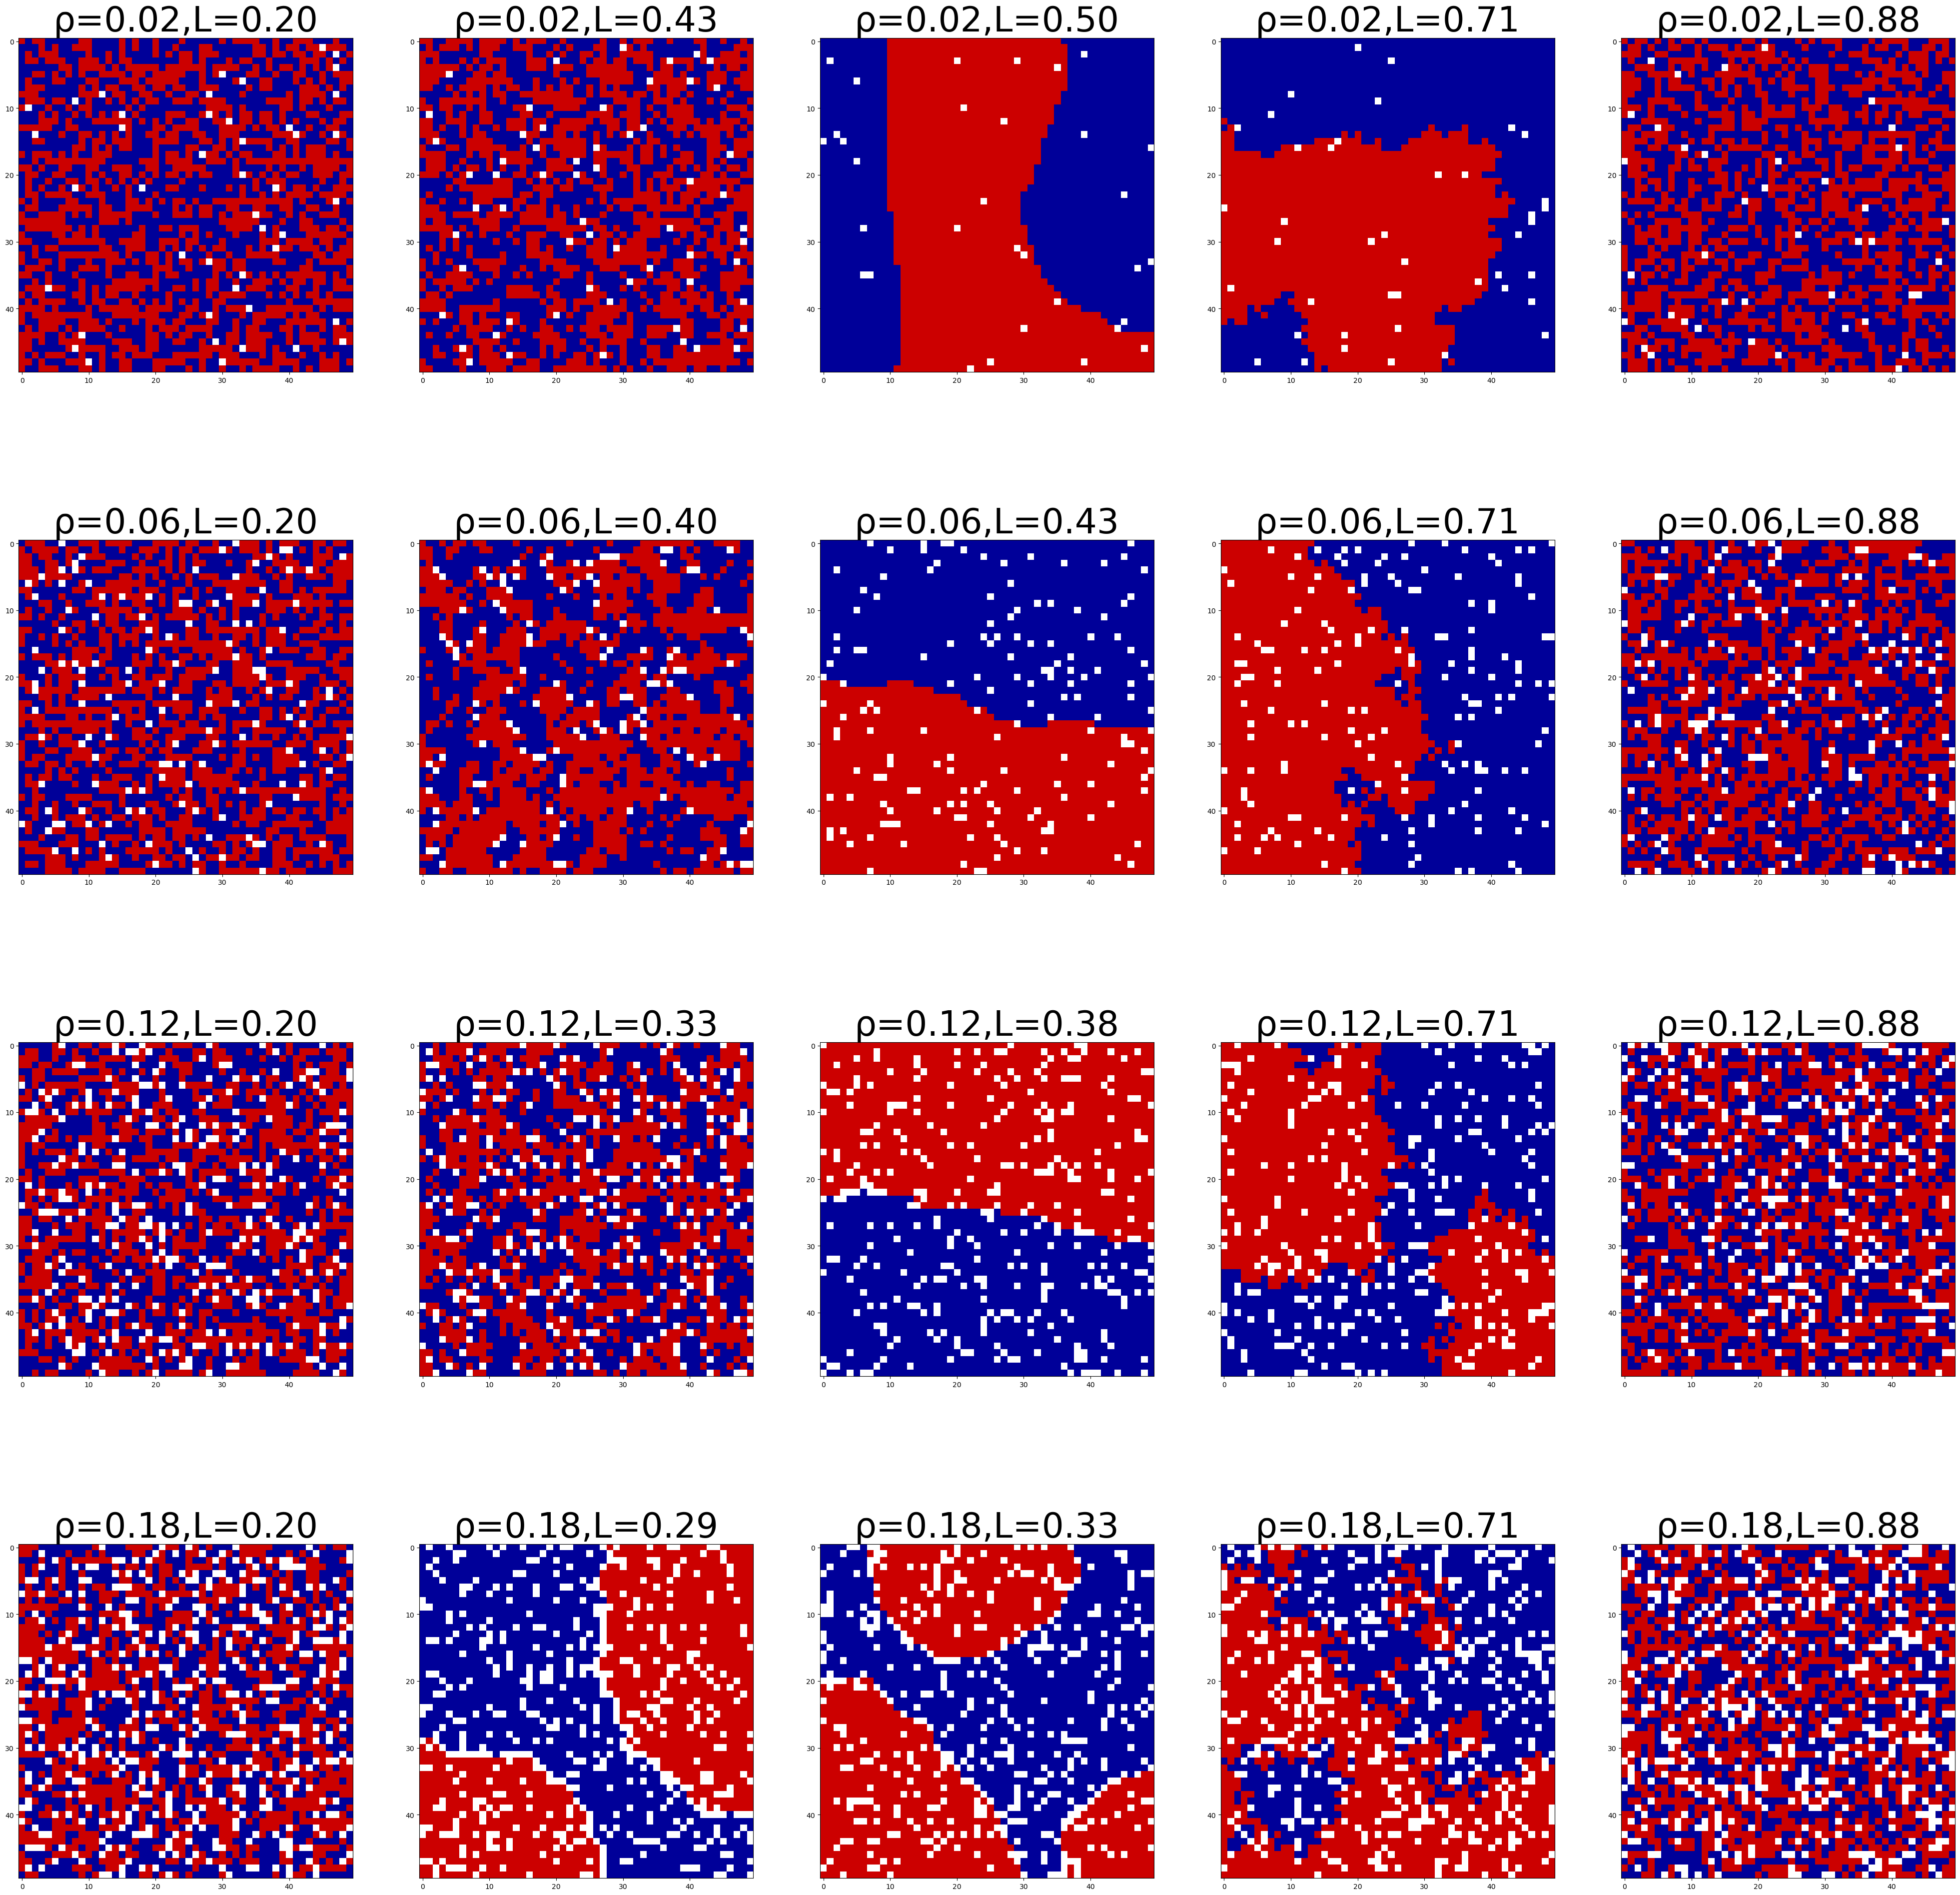

In [13]:
M = 50
Vide = [0.02, 0.06, 0.12, 0.18] 
T=200
L =np.array([[1/5, 3/7, 1/2, 5/7, 7/8],
             [1/5, 2/5, 3/7, 5/7, 7/8],
             [1/5, 1/3, 3/8, 5/7, 7/8],
             [1/5, 2/7, 1/3, 5/7, 7/8]])
           

fig = plt.figure(figsize=(50,50))
i=1
k=0
for v in Vide:  
    for l in L[k,:]:
        ax = fig.add_subplot(4,5,i)
        Grille = start(M,v)
        Grille = movement(Grille,M,l,T*M**2)
        ax.imshow(couleur_grille(Grille,M))
        plt.title(f'ρ={v},L={l:.2f}',size=50)
        sys.stdout.write(f"\r{str(i)}")
        #il faut atteindre 20 pour que le code se termine                          
        i+=1
    k+=1

Text(0.5, 0.98, 'Représentation des clusters')

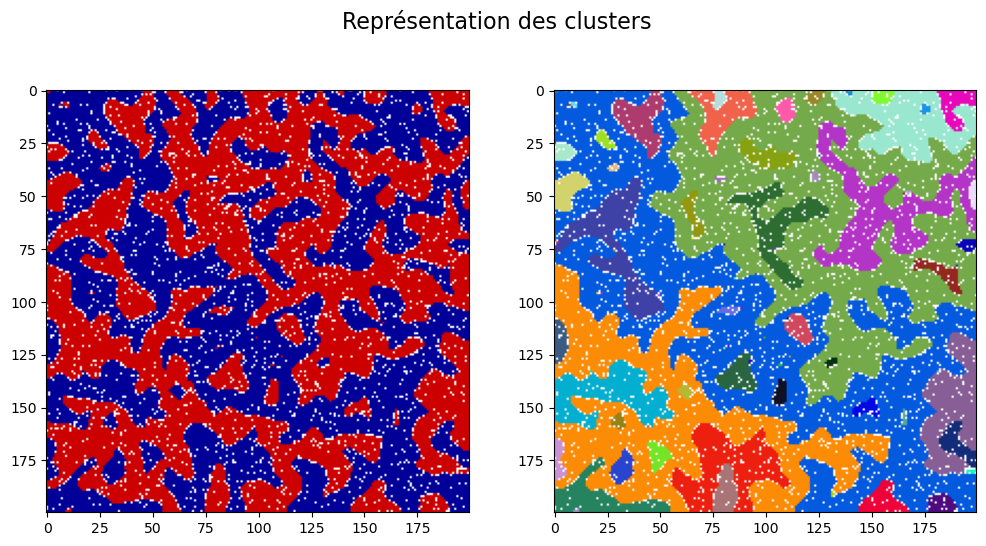

In [7]:
M = 200
L = 0.4
vide = 0.08
T = 10

Grille = start(M,vide)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

Grille= movement(Grille,M,L,M*M*T)  


ax1.imshow(couleur_grille(Grille,M)) 
Cluster = clusterfct(Grille,M)
ax2.imshow(couleur_cluster(clusterfct(Grille,M),M))
fig.suptitle('Représentation des clusters', fontsize=16)

79

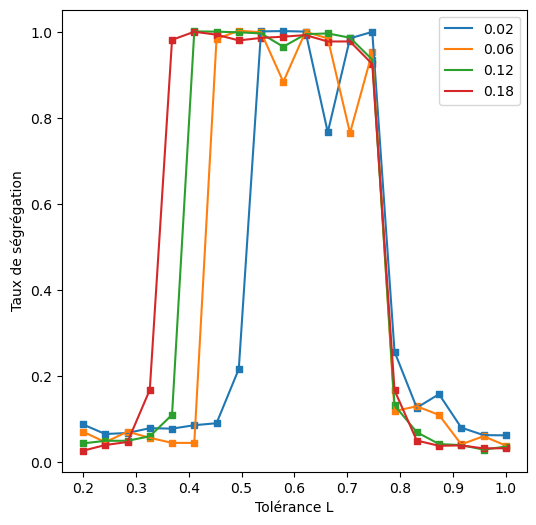

In [8]:
Liste = np.linspace(0.2,1,20)
Vide = [0.02, 0.06, 0.12, 0.18]
M = 30
T=400
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
i = 0
for v in Vide:
    SegregCoeff = []
    for l in Liste:
        Grille = start(M,v)
        Grille = movement(Grille,M,l,M*M*T)   
        Cluster = clusterfct(Grille,M)
        SegregCoeff.append(coeff(Grille,Cluster,M))
        sys.stdout.write(f"\r{str(i)}")
        i+=1
        #il faut atteindre 79 pour que le code se termine
             
    ax.plot(Liste,SegregCoeff,label=f'{v}')
    ax.scatter(Liste,SegregCoeff, s=20, marker='s')
    ax.legend()
    ax.set_ylabel('Taux de ségrégation')
    ax.set_xlabel('Tolérance L')

Text(0.5, 0.98, 'Variante du modèle de Schelling')

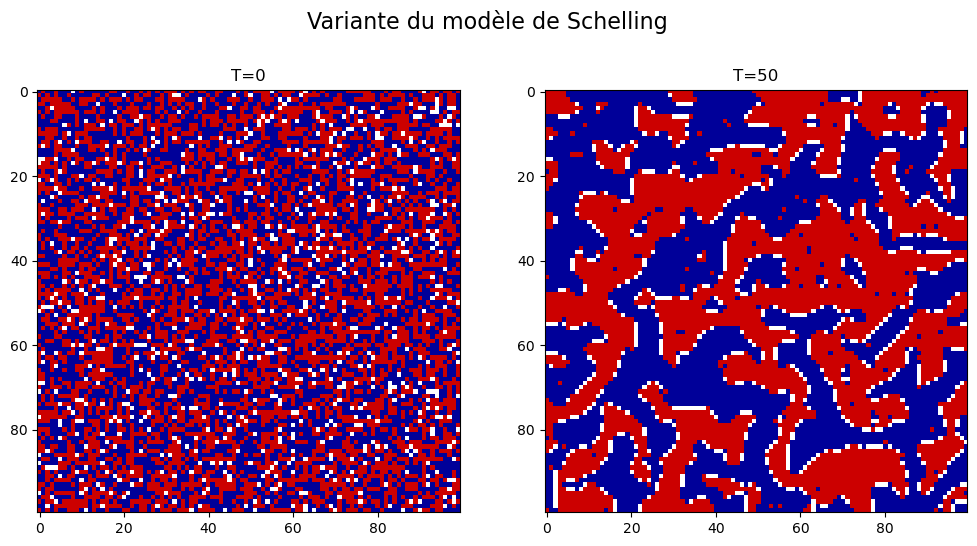

In [9]:
M = 100
L = 0.40
vide = 0.08
T = 50

Grille = start(M,vide)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(couleur_grille(Grille,M)) 
ax1.set_title(f'T=0')

Grille = movement2(Grille,M,L,M*M*T)  
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(couleur_grille(Grille,M))    
ax2.set_title(f'T={T}')
fig.suptitle('Variante du modèle de Schelling', fontsize=16)

Text(0.5, 1.0, 'Energie du modèle')

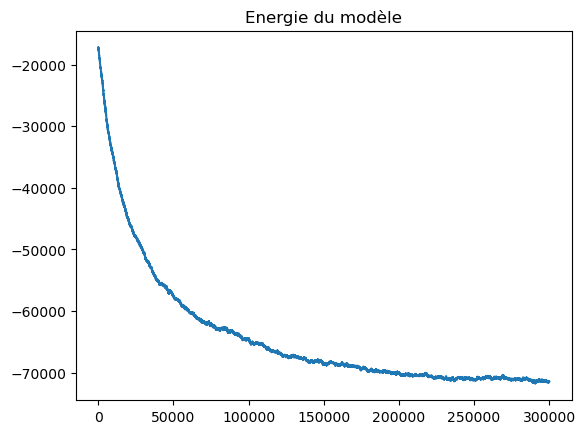

In [10]:
M = 100
L = 5/8
vide = 0.1
T = 30
xx = np.arange(0,T)

Grille = start(M,vide)
Grille,E = movement(Grille,M,L,M*M*T,True) 
#Quand on rajoute True en paramètre de movement, la fonction calcule également l'énergie à chaque itération et la renvoit. 
xx = np.arange(0,E.size)
plt.plot(xx,E)
plt.title('Energie du modèle')

Text(0.5, 1.0, 'Energie avec la variante du modèle')

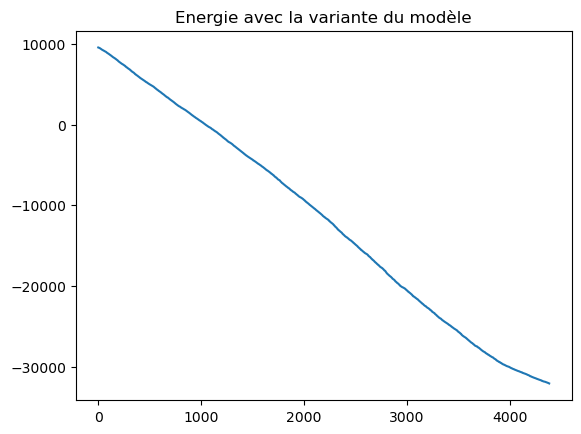

In [11]:
M = 80
L = 0.4
vide = 0.08
T = 200

Grille = start(M,vide)
Grille,E= movement2(Grille,M,L,M*M*T,True)  

xx = np.arange(0,E.size)
plt.plot(xx,E)
plt.title('Energie avec la variante du modèle')